In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = "#ffffff"

print('np.version: ', np.__version__)
print('pd.version: ', pd.__version__)
print('torch.version: ', torch.__version__)
print('torchvision.version: ', torchvision.__version__)
print('matplotlib.version: ', matplotlib.__version__)

np.version:  1.19.5
pd.version:  1.1.5
torch.version:  1.8.1+cu101
torchvision.version:  0.9.1+cu101
matplotlib.version:  3.2.2


In [2]:
dataset_path = 'drive/MyDrive/vehicle_dataset/'   ### Change the path here as per use

if os.path.exists(os.path.join(dataset_path, 'dataset.csv')):
    df = pd.read_csv(os.path.join(dataset_path, 'dataset.csv'))
    
else:
    df = list(np.array(np.arange(64*64*3),dtype=str)) + ['label']
    df = pd.DataFrame(columns=df)
    for name in tqdm(glob(os.path.join(dataset_path, 'vehicles/*'))):
        image = Image.open(name)
        img_seq = image.getdata()
        img = np.array(img_seq, dtype=np.uint8)
        img = img.flatten()
        img = np.append(img, 1)
        df = (df.append(dict(zip(df.columns, img)), ignore_index=True)).astype(np.uint8)
    
    for name in tqdm(glob(os.path.join(dataset_path, 'non-vehicles/*'))):
        image = Image.open(name)
        img_seq = image.getdata()
        img = np.array(img_seq, dtype=np.uint8)
        img = img.flatten()
        img = np.append(img, 0)
        df = (df.append(dict(zip(df.columns, img)), ignore_index=True)).astype(np.uint8)

    df.to_csv(os.path.join(dataset_path, 'dataset.csv'), index=False, encoding='utf-8-sig')

In [3]:
print(df.shape)
df.head()

(17760, 12289)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,45,61,55,55,69,64,51,65,60,45,59,55,48,64,59,46,59,56,33,41,40,40,48,48,64,74,75,83,95,94,42,55,54,34,49,49,30,42,42,39,...,21,32,33,22,31,32,23,30,32,23,30,30,26,36,31,66,74,68,74,76,69,77,78,70,76,78,66,76,75,64,77,78,68,75,79,69,73,78,70,1
1,48,59,33,70,58,31,72,55,27,48,52,20,30,56,28,44,52,30,59,50,29,56,54,25,54,55,29,52,55,32,52,55,33,53,61,30,57,51,31,49,...,109,103,101,109,104,100,110,102,100,108,104,100,107,105,102,107,106,107,105,105,106,103,105,105,102,106,104,101,109,103,108,109,103,110,106,104,110,103,106,1
2,19,30,22,24,35,27,33,48,39,34,48,37,42,50,43,46,54,46,30,38,35,30,38,36,29,37,35,25,31,29,25,34,28,27,42,33,28,45,30,42,...,112,117,99,115,122,104,119,125,107,121,126,106,120,123,104,117,120,99,113,117,95,119,123,102,116,126,103,119,125,104,115,125,103,117,130,108,121,130,110,1
3,47,65,63,48,63,62,51,63,62,58,67,64,60,68,62,55,64,57,50,56,50,48,55,48,47,54,48,53,57,53,75,77,74,95,102,99,120,130,126,150,...,100,110,101,100,112,103,102,115,107,103,118,110,103,118,111,104,118,111,106,118,112,107,119,113,107,120,113,108,121,114,110,123,116,112,124,118,112,124,118,1
4,135,152,147,135,152,145,136,151,142,136,149,139,135,146,136,127,136,128,121,128,118,116,123,105,111,120,98,108,119,98,103,119,94,99,120,90,99,124,91,103,...,94,119,121,95,117,121,99,118,122,101,119,122,102,117,121,102,118,122,103,120,125,102,120,124,101,119,122,103,118,123,105,117,124,107,118,126,108,119,127,1


In [4]:
target_data = torch.tensor((df.drop('label', axis=1)/255).values.astype(np.float64))
label_data = torch.tensor(df['label'].values.astype(np.int64))
data = TensorDataset(target_data, label_data)

image.shape:  torch.Size([64, 64, 3])
label:  1


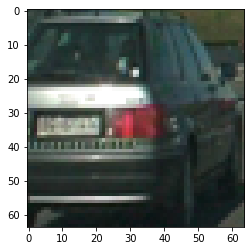

In [5]:
image, label = data[0]
print('image.shape: ', image.reshape(64,64,3).shape)
plt.imshow(image.reshape(64,64,3))
print('label: ', int(label))

image.shape:  torch.Size([64, 64, 3])
label:  0


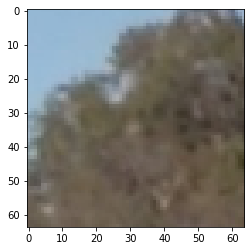

In [6]:
image, label = data[-1]
print('image.shape: ', image.reshape(64,64,3).shape)
plt.imshow(image.reshape(64,64,3))
print('label: ', int(label))

In [7]:
val_size = 2950
train_size = 14750
test_size = 60

train_ds, val_ds, test_ds = random_split(data, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(14750, 2950, 60)

In [8]:
batch_size = 128

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

inputs.shape:  torch.Size([128, 12288])
label.shape:  torch.Size([128])
images.shape:  torch.Size([128, 64, 64, 3])


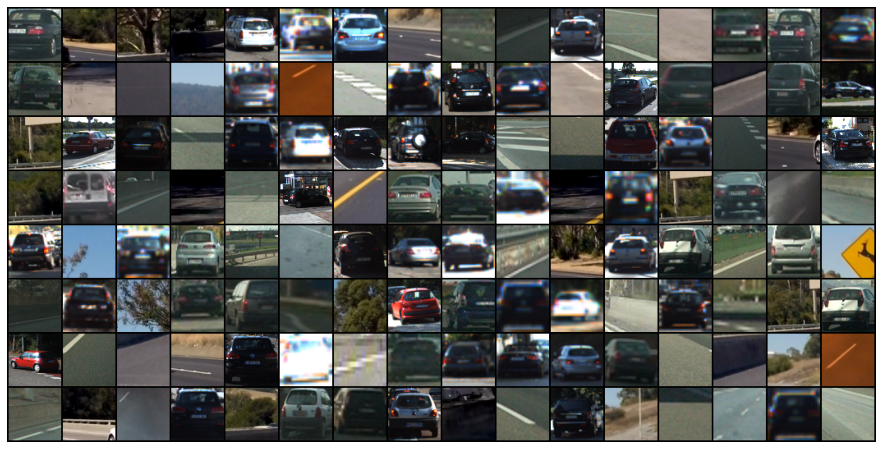

In [10]:
for images, label in train_loader:
    print('inputs.shape: ', images.shape)
    print('label.shape: ', label.shape)
    print('images.shape: ', images.reshape(128, 64, 64, 3).shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images.reshape(128,64,64,3).permute((0,3,1,2)), nrow=16).permute((1,2,0)))
    break

In [11]:
input_size = images.shape[1]
hidden_1_size = 1024
hidden_2_size = 64
hidden_3_size = 4
num_classes = 2

print('input_size: ', input_size)
print('hidden_layer_1_size: ', hidden_1_size)
print('hidden_layer_2_size: ', hidden_2_size)
print('hidden_layer_3_size: ', hidden_3_size)
print('output_size: ', num_classes)

input_size:  12288
hidden_layer_1_size:  1024
hidden_layer_2_size:  64
hidden_layer_3_size:  4
output_size:  2


In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [13]:
class VehicleModel(nn.Module):
    def __init__(self, in_size, hidden_1_size, hidden_2_size, hidden_3_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_1_size)
        self.linear2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.linear3 = nn.Linear(hidden_2_size, hidden_3_size)
        self.linear4 = nn.Linear(hidden_3_size, out_size)

    def forward(self, xb):
        xb = xb.float()
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
model = VehicleModel(in_size = input_size,
                     hidden_1_size = hidden_1_size,
                     hidden_2_size = hidden_2_size,
                     hidden_3_size = hidden_3_size,
                     out_size = num_classes)

In [15]:
for t in model.parameters():
    print(t.shape)

torch.Size([1024, 12288])
torch.Size([1024])
torch.Size([64, 1024])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
torch.Size([2, 4])
torch.Size([2])


In [16]:
torch.cuda.is_available()

False

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in tqdm(train_loader, leave=True):
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
model = VehicleModel(in_size = input_size,
                     hidden_1_size = hidden_1_size,
                     hidden_2_size = hidden_2_size,
                     hidden_3_size = hidden_3_size,
                     out_size = num_classes)

to_device(model, device)

VehicleModel(
  (linear1): Linear(in_features=12288, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=4, bias=True)
  (linear4): Linear(in_features=4, out_features=2, bias=True)
)

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.5164266228675842, 'val_loss': 0.6925045847892761}]

In [25]:
history += fit(10, 1, model, train_loader, val_loader)

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.6953, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.6961, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.6927, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.6959, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.6929, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.6976, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.7093, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.6974, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.6979, val_acc: 0.4836


100%|██████████| 116/116 [00:20<00:00,  5.63it/s]


Epoch [9], val_loss: 0.6928, val_acc: 0.5164


In [26]:
history += fit(10, 0.5, model, train_loader, val_loader)

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.6942, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.6941, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.6930, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.6928, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.6931, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.6941, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.6927, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.6926, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.6940, val_acc: 0.4836


100%|██████████| 116/116 [00:20<00:00,  5.70it/s]


Epoch [9], val_loss: 0.6931, val_acc: 0.5164


In [27]:
history += fit(10, 0.1, model, train_loader, val_loader)

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.6928, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.6927, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.6930, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.6929, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.6931, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.6933, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.6927, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.6948, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.6927, val_acc: 0.5164


100%|██████████| 116/116 [00:25<00:00,  4.59it/s]


Epoch [9], val_loss: 0.6931, val_acc: 0.5164


In [28]:
history += fit(10, 0.05, model, train_loader, val_loader)

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [0], val_loss: 0.6929, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [1], val_loss: 0.6928, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [2], val_loss: 0.6934, val_acc: 0.4836


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [3], val_loss: 0.6929, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [4], val_loss: 0.6931, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [5], val_loss: 0.6930, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [6], val_loss: 0.6931, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [7], val_loss: 0.6927, val_acc: 0.5164


  0%|          | 0/116 [00:00<?, ?it/s]

Epoch [8], val_loss: 0.6935, val_acc: 0.4836


100%|██████████| 116/116 [00:20<00:00,  5.68it/s]


Epoch [9], val_loss: 0.6929, val_acc: 0.5164


Text(0.5, 1.0, 'Loss vs. No. of epochs')

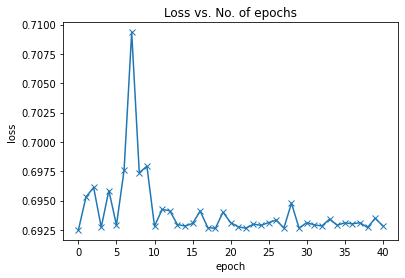

In [29]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

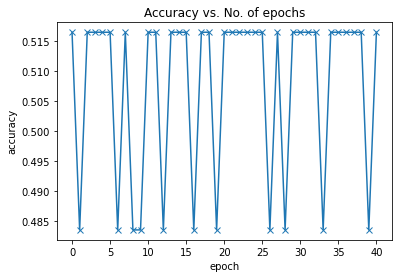

In [30]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')